<a href="https://colab.research.google.com/github/AtaruOhto/pytorch_learning/blob/master/cnn_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting ./data/cifar-10-python.tar.gz to ./data
CIFAR10のデータの数: 10000



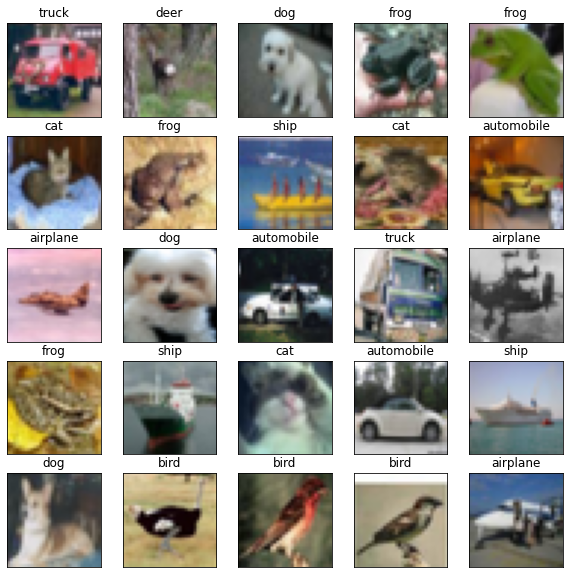

In [3]:
"""
参照: https://github.com/AtaruOhto/lecture_pytorch/blob/master/lecture4/cnn.ipynb

CIFAR10 Convolutional Neural Network
"""

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# CIFAR10のデータをダウンロード
cifar10_data = CIFAR10(root="./data",train=False,download=True,transform=transforms.ToTensor())
print("CIFAR10のデータの数:", len(cifar10_data))

# CIFAR10のクラス分類を定義
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck"])

# 表示する画像の数
n_image = 25

# 画像の表示サイズを設定 縦・横10
plt.figure(figsize=(10,10))  

# データをDataLoader形式に変換する。
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)

# https://github.com/pytorch/pytorch/issues/1917#issuecomment-311163345
# データローダーから最初のバッチを取り出す
images, labels =  (iter(cifar10_loader)).next() 

# 取り出したバッチをループ
for i in range(n_image):
    # plt.subplot(図を5行に分割、図を5列に分割、左上から数えてi + 1番目のプロット)
    plt.subplot(5, 5, i+1)
    
    # データの軸を入れ替えて、画像のチャンネルを一番後ろに持ってくる (画像を表示するため)
    # 画像のデータ形式: torch.Size([3, 32, 32]) => torch.Size([32, 32, 3])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))

    # ラベルを表示
    label = cifar10_classes[labels[i]]
    plt.title(label)

    # 目盛りを非表示にする
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  

plt.show()

Files already downloaded and verified


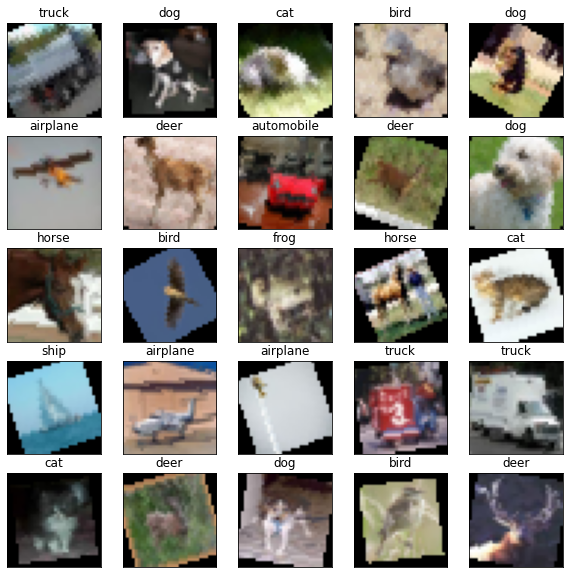

In [4]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# データ拡張 (Data Augmentationを実行する) = 過学習対策
# https://qiita.com/hoshiryu/items/f84d253b79184c903c27 (PyTorchでデータ拡張(Data Augmentation)を比較してみる)
transform = transforms.Compose(
  [
   transforms.RandomAffine(
       # 画像を-30度～30度の間で回転させる
       [-30, 30], 
       # 画像を 0.8 〜 1.2の間でスケーリングさせる
       scale=(0.8, 1.2)
       ),  
    transforms.ToTensor()
  ]
)

# CIFAR10のデータにデータ拡張を施す (transform=transform)
cifar10_data = CIFAR10(root="./data", train=False,download=True, transform=transform)

# 以下は上のコードセルと同じ処理をする。データ拡張 (Data Augumentation) された画像が表示される。
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
plt.figure(figsize=(10,10))
images, labels = (iter(cifar10_loader)).next()
for i in range(n_image):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0))) 
    label = cifar10_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False) 

plt.show()

In [5]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 画像に回転と拡大・縮小処理をかける。
affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2)) 

# https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip
# 50%の確率で画像を左右反転させる。
flip = transforms.RandomHorizontalFlip(p=0.5) 

# データの正規化をする (平均値を0、標準偏差を1に)
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))

# Converts a PIL Image or numpy.ndarray to a torch.FloatTensor of shape (C x H x W)
to_tensor = transforms.ToTensor()

# 訓練用データ用の変換形式のセット
transform_train = transforms.Compose([affine, flip, to_tensor, normalize])

# 訓練用データ用の変換形式のセット
transform_test = transforms.Compose([to_tensor, normalize])

# 上記で定義した変換形式のセットをかけて、訓練用データと検証用データを用意する
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
import torch.nn as nn
import torch.nn.functional as F

# CNN ニューラルネットワークを定義する
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 畳み込み層1 :(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.conv1 = nn.Conv2d(3, 6, 5)

        # 畳み込み層2 :(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # マックスプーリングを実施: （領域のサイズ, ストライド）
        self.pool = nn.MaxPool2d(2, 2) 

        # チャンネル数が16で5×5の画像が入力の全結合層
        self.fc1 = nn.Linear(16*5*5, 256) 

        # ドロップアウト:(p=ドロップアウト率) 
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # 1: torch.Size([64, 3, 32, 32]) 画像のデータ形式
        x = self.conv1(x)
        # 2: torch.Size([64, 6, 28, 28])
        x = F.relu(x)
        # 3: torch.Size([64, 6, 28, 28])
        x = self.pool(x)
        # 4: torch.Size([64, 6, 14, 14])
        x = self.conv2(x)
        # 5: torch.Size([64, 16, 10, 10])
        x = F.relu(x)
        # 6: torch.Size([64, 16, 10, 10])
        x = self.pool(x)
        # 7: torch.Size([64, 16, 5, 5])
        x = x.view(-1, 16*5*5)
        # 8: torch.Size([64, 400])
        x = self.fc1(x)
        # 9 torch.Size([64, 256])
        x = F.relu(x)
        # 10: torch.Size([64, 256])
        x = self.dropout(x)
        # 画像は10種類あるので、10で出力する。
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [19]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
x_test, t_test = iter(test_loader).next()
x_test, t_test = x_test.cuda(), t_test.cuda()

# 20エポックで学習
for i in range(20):  
    # 訓練モード
    net.train()  
    loss_train = 0

    # ミニバッチ（x, t）を取り出す
    for j, (x, t) in enumerate(train_loader):
        # GPU対応
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)

        # 損失を記録
        loss_train += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    # 評価モード (ドロップアウトなどは実行しない)
    net.eval()  
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i % 1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.5776357882467986 Loss_Test: 1.4458122253417969
Epoch: 1 Loss_Train: 1.4961678858303353 Loss_Test: 1.3638529777526855
Epoch: 2 Loss_Train: 1.4494066973171575 Loss_Test: 1.3173540830612183
Epoch: 3 Loss_Train: 1.4142587216918732 Loss_Test: 1.294968843460083
Epoch: 4 Loss_Train: 1.3858126978130292 Loss_Test: 1.2535400390625
Epoch: 5 Loss_Train: 1.3571315499980126 Loss_Test: 1.2741496562957764
Epoch: 6 Loss_Train: 1.3431311957823955 Loss_Test: 1.2079823017120361
Epoch: 7 Loss_Train: 1.3257073073283485 Loss_Test: 1.213082194328308
Epoch: 8 Loss_Train: 1.3098960156788302 Loss_Test: 1.1907002925872803
Epoch: 9 Loss_Train: 1.2926091230891246 Loss_Test: 1.159952163696289
Epoch: 10 Loss_Train: 1.282467569917669 Loss_Test: 1.1614058017730713
Epoch: 11 Loss_Train: 1.2750940418914152 Loss_Test: 1.1640913486480713
Epoch: 12 Loss_Train: 1.2590272712433124 Loss_Test: 1.124931812286377
Epoch: 13 Loss_Train: 1.2525406283948122 Loss_Test: 1.1108136177062988
Epoch: 14 Loss_Train: 1.

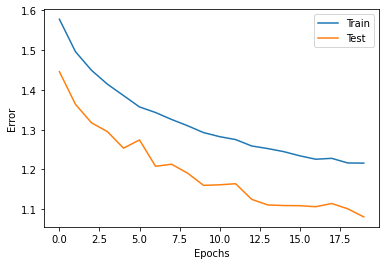

In [22]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [35]:

correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print(f"正解率: {correct / total * 100}%")

正解率: 62.09%


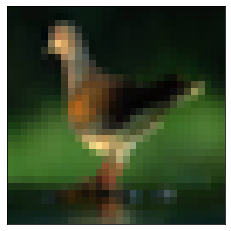

正解: bird 予測結果: bird


In [32]:

cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = dataiter.next()  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

net.eval()  # 評価モード
x, t = images.cuda(), labels.cuda()  # GPU対応
y = net(x)
print("正解:", cifar10_classes[labels[0]],
      "予測結果:", cifar10_classes[y.argmax().item()])